# Access ESASky products with astroquery.esasky

##### Authors: Ivan Valtchanov, Belén López Martí, H. Norman

#### Last update: Feb 7, 2019


This notebook illustrates some example usages of the ESASky implementation in astroquery.

First you need to install astroquery and esasky.

Astroquery can be installed with pip install astroquery, the latest version should come with esasky. Alternatively, you can grab the latest astroquery with esasky from [here](https://github.com/imbasimba/astroquery).

The documentation for astroquery.esasky is available [here](https://astroquery.readthedocs.io/en/latest/esasky/esasky.html).




### Use Case 1: Retrieve imaging data for a single object

In this use case, imaging data are retrieved for a single object, indicated by its name (resolved by Simbad) or coordinates.

We start by importing the ESASky astroquery module and other necessary packages:


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
from astroquery.esasky import ESASky

First, let's check the available maps: 

In [2]:
ESASky.list_maps()

['INTEGRAL',
 'XMM',
 'Chandra',
 'SUZAKU',
 'XMM-OM-OPTICAL',
 'XMM-OM-UV',
 'HST',
 'Herschel',
 'ISO']

Let's do a search around the position of our object:

In [3]:
maps = ESASky.query_object_maps('M51')
print (maps)

TableList with 7 tables:
	'0:XMM' with 10 column(s) and 6 row(s) 
	'1:CHANDRA' with 10 column(s) and 16 row(s) 
	'2:XMM-OM-OPTICAL' with 11 column(s) and 4 row(s) 
	'3:XMM-OM-UV' with 10 column(s) and 5 row(s) 
	'4:HST' with 12 column(s) and 156 row(s) 
	'5:HERSCHEL' with 12 column(s) and 9 row(s) 
	'6:ISO' with 7 column(s) and 4 row(s) 


The output is a TableList with the keys corresponding to the mission (or in some cases, mission and instrument) names for which there are images available covering our target position.

We can also do a search by coordinates, either by using an [astroquery.coordinates](http://docs.astropy.org/en/stable/coordinates/) object or by typing the coordinates. In this latter case, we have to define the units we are using (d = degrees; h = hours; m = minutes; s = seconds).

In [4]:
maps = ESASky.query_object_maps('13h29m52.7s +47d11m43s')
print (maps)

/Users/belenlopezmarti/anaconda3/lib/python3.6/site-packages/astroquery/utils/commons.py:159: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


TableList with 7 tables:
	'0:XMM' with 10 column(s) and 6 row(s) 
	'1:CHANDRA' with 10 column(s) and 16 row(s) 
	'2:XMM-OM-OPTICAL' with 11 column(s) and 4 row(s) 
	'3:XMM-OM-UV' with 10 column(s) and 5 row(s) 
	'4:HST' with 12 column(s) and 156 row(s) 
	'5:HERSCHEL' with 12 column(s) and 9 row(s) 
	'6:ISO' with 7 column(s) and 4 row(s) 


The method has a tolerance of 5 arcsec to allow for positional errors.

Let's check the content of the 'XMM-OM-OPTICAL' table:

In [5]:
maps['XMM-OM-UV'].info

<Table masked=True length=5>
     name       dtype  format
-------------- ------- ------
  postcard_url  object       
   product_url  object       
observation_id  object       
    instrument  object       
        filter  object       
        ra_deg float64 {!r:>}
       dec_deg float64 {!r:>}
     start_utc  object       
      duration   int64       
         stc_s  object       

As we see, it contains a table with URLs for the maps, and some additional info, like map ra, dec, bandpass ('filter'), or the exposure time ('duration').

Let's now see what bands are available:

In [6]:
maps['XMM-OM-OPTICAL']['observation_id', 'instrument', 'filter', 'duration'].pprint()

observation_id instrument filter duration
-------------- ---------- ------ --------
    0212480801         OM      B    49214
    0212480801         OM      U    49214
    0212480801         OM      V    49214
    0303420101         OM      U    54114


The result is stored in memory. To get the actual images:

In [7]:
#
# set the download dir for ESASky products
#
download_dir = os.path.expanduser('~') + "/Downloads/" # change this to your desired directory

maps_data = ESASky.get_maps(maps,'XMM-OM-OPTICAL', download_dir)  

Starting download of XMM-OM-OPTICAL data. (4 files)
INFO: Maps available at /Users/dbaines/Downloads [astroquery.esasky.core]


In [8]:
maps_data

{'XMM-OM-OPTICAL': [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11ff7c6a0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x11ff8c860>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12086f828>],
  [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11ff9c198>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12086fe48>, <astropy.io.fits.hdu.image.ImageHDU object at 0x120879470>],
  [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x120864a20>, <astropy.io.fits.hdu.image.ImageHDU object at 0x120879a58>, <astropy.io.fits.hdu.image.ImageHDU object at 0x120879fd0>],
  [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11ffa3710>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12087c668>, <astropy.io.fits.hdu.image.ImageHDU object at 0x12087cc50>]]}

The output maps_data is a product containing all the FITS files in memory, which are also downloaded to a local folder. If no folder is specified, the current working directory is used by default.

It is possible to download all the available images at once by typing 'all' as the mission name in the ESASky.get_maps() method.
    
We are ready to work with these maps. For example, let's inspect the header of one of them:

In [9]:
hdu = maps_data["XMM-OM-OPTICAL"][3]
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2951 / length of data axis 1                          
NAXIS2  =                 2925 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
BUNIT   = 'Primary Array'      / Units of the image                             
XPROC0  = 'ommosaic imagesets=''product/P0303420101OMS006FSIMAGU000.FIT produc&'
CONTINUE  't/P0303420101OMS007FSIMAGU000.FIT product/P0303420101OMS008FSIMAGU0&'
CONTINUE  '00.FIT'' mosaicedset=product/P0303420101OMX000HSIMAGU000.FIT correl&'
CONTINUE  'set='''' nsigma=2 mincorr=0 minfraction=0.5 maxdx=5 binaxis=0 numin&'
CONTINUE  'tervals=2 di=10 minnumpixels=100 # (ommosaic-2.5.17) [xmmsas_201212&'
CONTINUE  '19_1645-12.0.1]' 

Let's now display it:

/Users/dbaines/anaconda/envs/my_pymc_env/lib/python3.6/site-packages/matplotlib/image.py:412: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


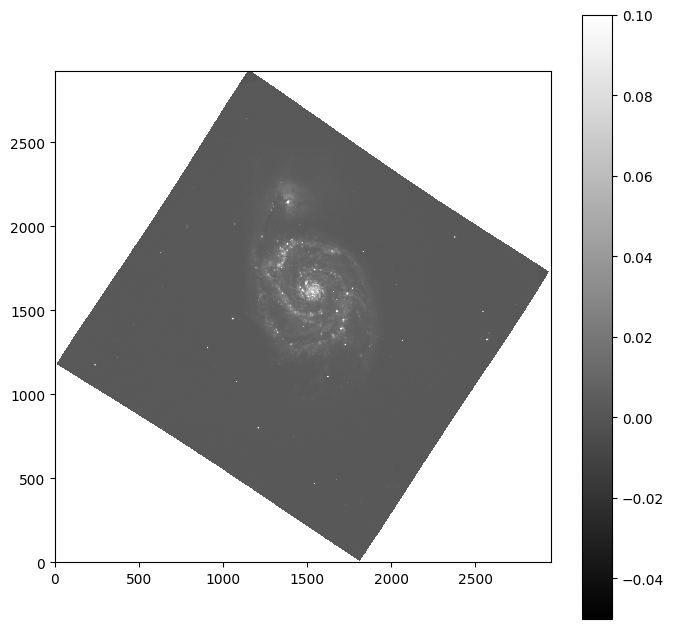

In [10]:
image = hdu[0].data

from astropy import visualization 
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, ManualInterval)

# Create an ImageNormalize object
#norm = ImageNormalize(image, interval=MinMaxInterval(), stretch=SqrtStretch())
norm = ImageNormalize(image, interval = ManualInterval(-0.05,0.1))

# Display the image
fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, cmap='gray', origin='lower', norm=norm)
fig.colorbar(im)



### Use Case 2: Retrieve catalogue data for a single object

We will now inspect and retrieve the catalogue data available for a given object, using either a name (resolved by Simbad) or coordinates.

As we did in Use Case 1 with the images, let's first get a list of the available catalogues:


In [11]:
ESASky.list_catalogs()

['AllWise',
 '2MASS',
 'INTEGRAL',
 'CHANDRA',
 'XMM-EPIC-STACK',
 'XMM-EPIC',
 'XMM-OM',
 'XMM-SLEW',
 'Tycho-2',
 'Gaia DR2',
 'Hipparcos-2',
 'HSC',
 'Herschel-HPPSC-070',
 'Herschel-HPPSC-100',
 'Herschel-HPPSC-160',
 'Herschel-SPSC-250',
 'Herschel-SPSC-350',
 'Herschel-SPSC-500',
 'Planck-PGCC2',
 'Planck-PCCS2E-HFI',
 'Planck-PCCS2-HFI',
 'Planck-PCCS2-LFI',
 'Planck-PSZ']

We can look for an object in these catalogues by name or coordinates:

In [12]:
cats = ESASky.query_object_catalogs('M51')
print (cats)

TableList with 8 tables:
	'0:ALLWISE' with 13 column(s) and 1 row(s) 
	'1:2MASS' with 9 column(s) and 3 row(s) 
	'2:XMM-EPIC-STACK' with 14 column(s) and 1 row(s) 
	'3:XMM-EPIC' with 6 column(s) and 2 row(s) 
	'4:XMM-OM' with 12 column(s) and 3 row(s) 
	'5:HSC' with 8 column(s) and 34 row(s) 
	'6:HERSCHEL-HPPSC-070' with 15 column(s) and 1 row(s) 
	'7:HERSCHEL-HPPSC-100' with 15 column(s) and 1 row(s) 


In [13]:
cats = ESASky.query_object_catalogs('13 29 52.7 +47 11 43')
print (cats)

TableList with 8 tables:
	'0:ALLWISE' with 13 column(s) and 1 row(s) 
	'1:2MASS' with 9 column(s) and 2 row(s) 
	'2:XMM-EPIC-STACK' with 14 column(s) and 1 row(s) 
	'3:XMM-EPIC' with 6 column(s) and 2 row(s) 
	'4:XMM-OM' with 12 column(s) and 3 row(s) 
	'5:HSC' with 8 column(s) and 35 row(s) 
	'6:HERSCHEL-HPPSC-070' with 15 column(s) and 1 row(s) 
	'7:HERSCHEL-HPPSC-100' with 15 column(s) and 1 row(s) 


As in the previous use case, the query results are stored in a TableList with the keys corresponding to the catalog name. 

It is also possible to specify the catalogues to search:

In [14]:
cats = ESASky.query_object_catalogs('M51',["XMM-EPIC","XMM-SLEW", "HSC"])
print (cats)

TableList with 2 tables:
	'0:XMM-EPIC' with 6 column(s) and 2 row(s) 
	'1:HSC' with 8 column(s) and 34 row(s) 


In this example, we only get two tables, because there are no available sources in the XMM-SLEW catalogue.

Let's now visualise the XMM-EPIC results table:

In [15]:
hsc_table = cats["HSC"]
hsc_table.info()

<Table masked=True length=34>
    name      dtype  format
------------ ------- ------
    match_id   int64       
        name  object       
  num_images   int32       
          ra float64 {!r:>}
         dec float64 {!r:>}
      fluxes  object       
fluxesvalues  object       
 sigmavalues  object       


In [16]:
print (hsc_table)

match_id   name   ...              sigmavalues              
-------- -------- ... --------------------------------------
 8984035  NGC5194 ... 0.0000, 0.0000, 0.0000, 0.0092, 0.0000
 9146957 SN2005CS ... 0.0000, 0.0000, 0.0000, 0.0000, 0.3905
 8992625 SN2005CS ...         0.0000, 0.0000, 0.0000, 0.0000
 9004677    M51-3 ...                         0.1920, 0.0000
 8986000    M51-3 ...                         0.3470, 0.0000
 8992912    M51-3 ...                         0.2579, 0.0000
 9147680    M51-3 ...                                 0.0094
 8980663    M51-3 ...                         0.0000, 0.0000
 8981956    M51-3 ...                                 0.1599
 8985840  NGC5194 ...                         0.0000, 0.0000
     ...      ... ...                                    ...
 8969716    M51-3 ...                                 0.0000
 9005534    M51-1 ...                                 0.0000
 9146006    M51-3 ...                                 0.0000
 8996950  SN1994I ...   

We can also choose the columns to display:

In [17]:
print (hsc_table['name', 'ra', 'dec'])

  name           ra                dec        
-------- ------------------ ------------------
 NGC5194  202.4696214722941  47.19528395791828
SN2005CS 202.47117517567187  47.19468973805837
SN2005CS 202.46967663414804    47.195137221641
   M51-3 202.46871789371008   47.1959885181474
   M51-3 202.47070891462116  47.19427421105356
   M51-3 202.46809779496715  47.19600783872095
   M51-3   202.470340592702  47.19614826226936
   M51-3 202.46897225496647 47.194237136942014
   M51-3 202.47081446307865  47.19420906449286
 NGC5194 202.46983100759005  47.19420861917729
     ...                ...                ...
   M51-3 202.46771650529647  47.19475631194131
   M51-1 202.47146559032703 47.195541069192046
   M51-3 202.46842740940812 47.194226813381455
 SN1994I 202.46894157707743  47.19545431189097
   M51-3 202.46811100328185   47.1954417127405
 SN1994I 202.46991550718963  47.19531492645547
   M51-3 202.46770040291568   47.1952897119087
   M51-3  202.4688063032161  47.19585541414903
 SN1994I 202.

Let's plot these sources:

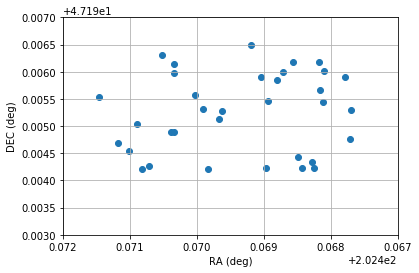

In [18]:
plt.xlabel('RA (deg)')
plt.ylabel('DEC (deg)')
plt.xlim(reversed(plt.xlim(202.467,202.472)))
plt.ylim(47.193,47.197)
plt.scatter(hsc_table['ra'], hsc_table['dec'])
plt.grid(True)



### Use Case 3: Retrieve data in a sky region

It is also possible retrieve imaging and catalogue data in a circular sky region. The procedure is very similar to the case of a single object discussed above, but using the query_region_maps() and query_region_catalogs() methods instead of query_object_maps() and query_object_catalogs(). 

Let's first see the case where imaging data are retrieved. To query the region, we have to enter the central coordinates and the radius:

In [19]:
maps = ESASky.query_region_maps('13 29 52.7 +47 11 43', '25 arcmin')
print (maps)

TableList with 8 tables:
	'0:INTEGRAL' with 8 column(s) and 1 row(s) 
	'1:XMM' with 10 column(s) and 6 row(s) 
	'2:CHANDRA' with 10 column(s) and 16 row(s) 
	'3:XMM-OM-OPTICAL' with 11 column(s) and 4 row(s) 
	'4:XMM-OM-UV' with 10 column(s) and 5 row(s) 
	'5:HST' with 12 column(s) and 650 row(s) 
	'6:HERSCHEL' with 12 column(s) and 25 row(s) 
	'7:ISO' with 7 column(s) and 10 row(s) 


The difference with the query_object_maps() module is that now we have to explicitly indicate the search radius; if not, an error message is returned.

To search in a region around a given object, we can also enter the object's name instead of its coordinates:

In [20]:
maps = ESASky.query_region_maps('M51', '25 arcmin')
print (maps)

TableList with 8 tables:
	'0:INTEGRAL' with 8 column(s) and 1 row(s) 
	'1:XMM' with 10 column(s) and 6 row(s) 
	'2:CHANDRA' with 10 column(s) and 16 row(s) 
	'3:XMM-OM-OPTICAL' with 11 column(s) and 4 row(s) 
	'4:XMM-OM-UV' with 10 column(s) and 5 row(s) 
	'5:HST' with 12 column(s) and 650 row(s) 
	'6:HERSCHEL' with 12 column(s) and 25 row(s) 
	'7:ISO' with 7 column(s) and 10 row(s) 


If we compare the result of this query with that of Use Case 1, we will see that now we get more data, because we are using a larger search radius (recall that the search by object uses a radius of only 5 arcsec). In particular, we now have INTEGRAL data, and the number of observations from the other missions has increased.

The query for catalogues works similarly:

In [21]:
cats = ESASky.query_region_catalogs('M51',"25 arcmin",["XMM-EPIC", "HSC"])
print (cats)

TableList with 2 tables:
	'0:XMM-EPIC' with 6 column(s) and 565 row(s) 
	'1:HSC' with 8 column(s) and 10000 row(s) 


We also note here how the number of rows in each table is larger than before, because of the larger search radius. 

By default, the query returns a maximum of 10,000 rows per table. Note that this limit has been reached for the HSC. If we want to make sure that all the rows are retrieved, we can set the row_limit parameter to -1:

In [22]:
cats = ESASky.query_region_catalogs('M51',"25 arcmin",["XMM-EPIC", "HSC"], row_limit=-1)
print (cats)

TableList with 2 tables:
	'0:XMM-EPIC' with 6 column(s) and 565 row(s) 
	'1:HSC' with 8 column(s) and 100000 row(s) 


Now the number of rows in the HSC table is 100,000, which is the absolute maximum that can be queried.

Let's now see how the XMM-EPIC table looks like:

In [23]:
xmm_epic_table = cats["XMM-EPIC"]
print (xmm_epic_table)

                                                                      postcard_url                                                                       ...
-------------------------------------------------------------------------------------------------------------------------------------------------------- ...
http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=POSTCARD&EPIC_SOURCE_CAT_OID=454471&EPIC_SOURCE_CAT_PRODUCT_TYPE=IMAGE&PROTOCOL=HTTP ...
http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=POSTCARD&EPIC_SOURCE_CAT_OID=454470&EPIC_SOURCE_CAT_PRODUCT_TYPE=IMAGE&PROTOCOL=HTTP ...
http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=POSTCARD&EPIC_SOURCE_CAT_OID=454915&EPIC_SOURCE_CAT_PRODUCT_TYPE=IMAGE&PROTOCOL=HTTP ...
http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRIEVAL_TYPE=POSTCARD&EPIC_SOURCE_CAT_OID=455884&EPIC_SOURCE_CAT_PRODUCT_TYPE=IMAGE&PROTOCOL=HTTP ...
http://nxsa.esac.esa.int/nxsa-sl/servlet/data-action?RETRI

We are ready to work with the data. For example, let's plot a histogram of the EPIC fluxes:

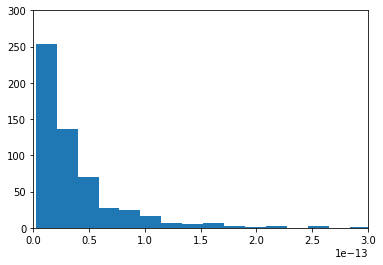

In [24]:
NBINS = 100
plt.xlim(0, 3e-13)
plt.ylim(0,300)
flux = plt.hist(xmm_epic_table['ep_8_flux'], NBINS)